#**Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np


from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#**Dataset**

In [3]:
df_train = pd.read_csv("Dataset/housing_coursework_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("Dataset/housing_coursework_test.csv", encoding="ISO-8859-1")


In [4]:
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-122.21,37.83,34,5065,788.0,1627,766,6.8976,333300,NEAR BAY
1,2,-122.22,37.77,52,391,128.0,520,138,1.6471,95000,NEAR BAY
2,3,-122.23,37.79,30,610,145.0,425,140,1.6198,122700,NEAR BAY
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,NEAR BAY
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,NEAR BAY
5,6,-122.19,37.76,26,1293,297.0,984,303,1.9479,85800,NEAR BAY
6,7,-122.17,37.74,43,818,193.0,494,179,2.4776,101600,NEAR BAY
7,8,-122.18,37.75,46,941,218.0,621,195,1.3250,87100,NEAR BAY
8,9,-122.16,37.75,38,2457,624.0,1516,482,1.5625,91700,NEAR BAY
9,10,-122.14,37.75,33,1334,200.0,579,202,6.8323,255900,NEAR BAY


In [5]:
def scatter_plot(feature, target):
    plt.figure(figsize=(8, 4))
    plt.scatter(
        df_train[feature],
        df_train[target],
        c='black'
    )
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

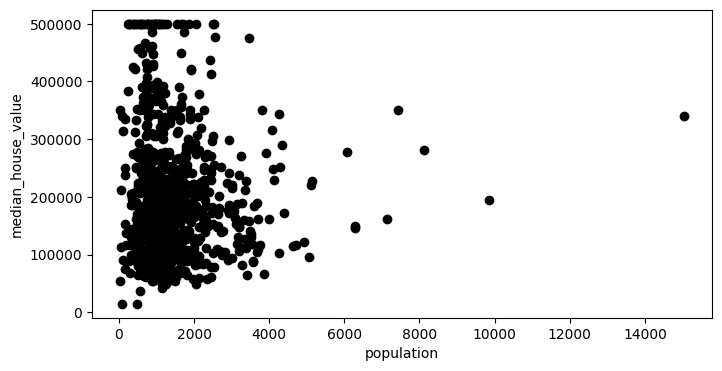

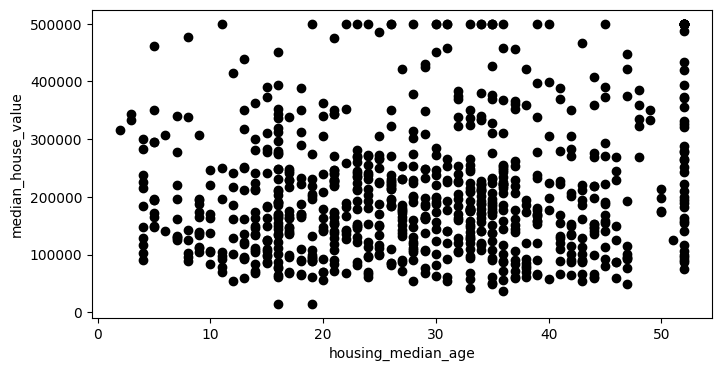

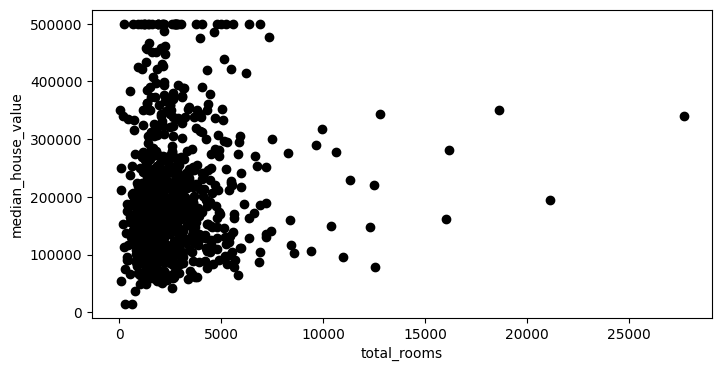

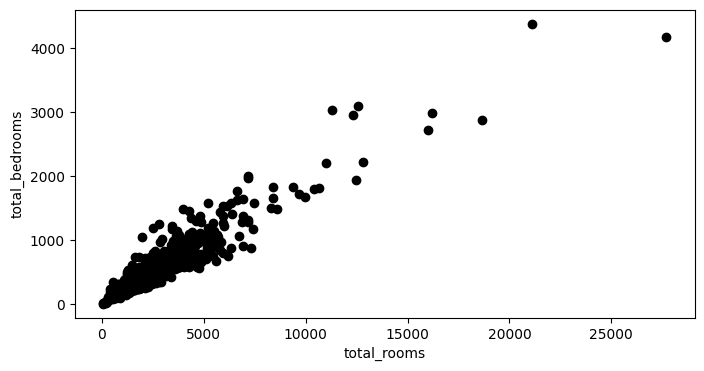

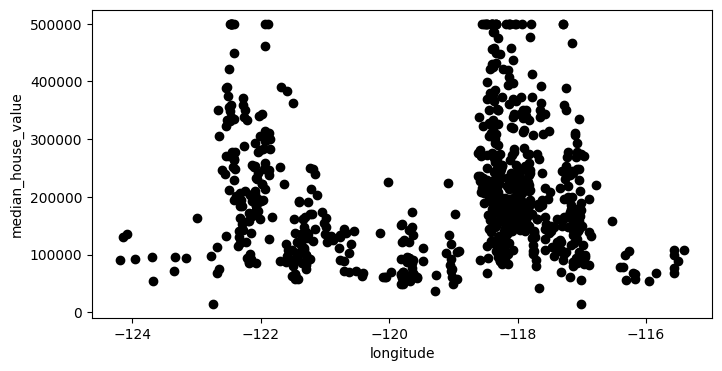

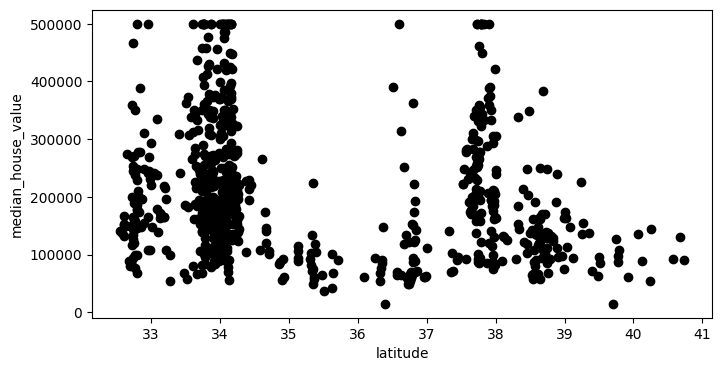

In [24]:
#Attempting to identifying correlations
scatter_plot('population', 'median_house_value')
scatter_plot('housing_median_age', 'median_house_value')
scatter_plot('total_rooms', 'median_house_value')
scatter_plot('total_rooms', 'total_bedrooms')
scatter_plot('longitude', 'median_house_value')
scatter_plot('latitude', 'median_house_value')




#**Preprocessing**

In [7]:
#Detecting NaN vaues
print("Trainin set: \n",df_train.loc[df_train.isnull().any(axis=1)])
print("Test set: \n",df_test.loc[df_test.isnull().any(axis=1)])

Trainin set: 
      No.  longitude  latitude  housing_median_age  total_rooms  \
72    73    -122.08     37.88                  26         2947   
168  169    -118.28     34.25                  29         2559   
236  237    -118.38     34.05                  49          702   
548  549    -117.87     33.83                  27         2287   
621  622    -116.21     33.75                  22          894   
740  741    -117.02     32.66                  19          771   
786  787    -122.45     37.77                  52         2602   
792  793    -122.50     37.75                  45         1620   

     total_bedrooms  population  households  median_income  \
72              NaN         825         626         2.9330   
168             NaN        1886         769         2.6036   
236             NaN         458         187         4.8958   
548             NaN        1140         351         5.6163   
621             NaN         830         202         3.0673   
740             Na

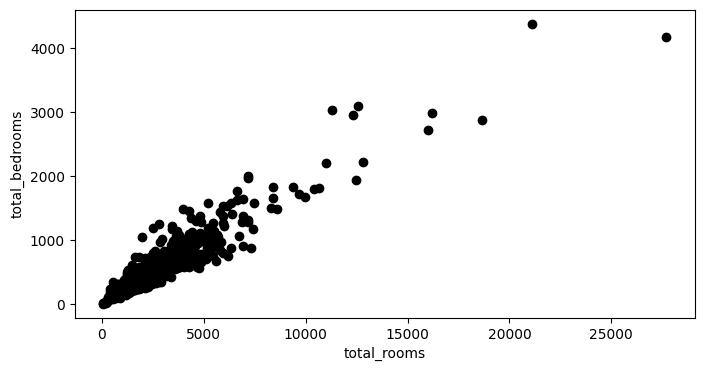

In [8]:
#Filling Nan total_bedrooms data points with using the average ratio of bedrooms to total rooms.
scatter_plot('total_rooms', 'total_bedrooms')

sum_total_rooms = df_train['total_rooms'].sum()

sum_total_bedrooms = df_train['total_bedrooms'].sum()

average_room_bedroom_ratio = sum_total_bedrooms/sum_total_rooms
for index, row in df_train.iterrows():
    if(np.isnan(row['total_bedrooms'])):
        df_train.at[index, 'total_bedrooms',] = row['total_rooms'] * average_room_bedroom_ratio

sum_total_rooms = df_test['total_rooms'].sum()

sum_total_bedrooms = df_test['total_bedrooms'].sum()

average_room_bedroom_ratio = sum_total_bedrooms/sum_total_rooms
for index, row in df_test.iterrows():
    if(np.isnan(row['total_bedrooms'])):
        df_test.at[index, 'total_bedrooms',] = row['total_rooms'] * average_room_bedroom_ratio

In [9]:
#Shuffle dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head(10)

df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(10)


,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,836,-122.19,37.43,39,2392,420.0,937,406,6.6136,472800,NEAR OCEAN
1,972,-122.34,40.32,12,3848,689.0,2008,683,2.6352,92200,INLAND
2,842,-119.72,34.41,26,1648,378.0,954,405,3.2895,335000,NEAR OCEAN
3,843,-119.52,34.41,20,4489,800.0,2867,765,4.8060,279700,<1H OCEAN
4,856,-121.89,37.34,43,1423,467.0,1013,428,1.6708,204200,<1H OCEAN
5,824,-120.70,35.28,14,3768,682.0,1884,664,4.6071,239900,NEAR OCEAN
6,887,-122.06,37.30,11,5488,706.0,1947,641,10.7326,500001,<1H OCEAN
7,864,-121.79,37.33,13,2978,505.0,1794,485,6.6813,277800,<1H OCEAN
8,995,-119.04,34.34,35,462,90.0,334,96,5.3582,281300,<1H OCEAN
9,818,-121.21,37.81,8,1883,298.0,999,301,5.1930,172100,INLAND


In [10]:
# Integer encoding ocean proximity
df_train['ocean_proximity']=np.where(df_train['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_train['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_train['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_train['ocean_proximity'] == 'NEAR BAY', 3 , df_train['ocean_proximity']))))

df_test['ocean_proximity']=np.where(df_test['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_test['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_test['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_test['ocean_proximity'] == 'NEAR BAY', 3 , df_test['ocean_proximity']))))                           
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,505,-117.87,33.85,33,45,11.0,34,10,5.2949,350000,1
1,36,-122.05,37.57,7,10648,1818.0,6075,1797,6.1047,278200,3
2,362,-118.19,33.93,44,1613,345.0,1227,342,3.1667,145700,1
3,134,-119.00,35.36,35,1021,280.0,1258,239,1.7375,48600,0
4,584,-121.15,38.89,20,2024,313.0,879,309,5.2903,239400,0
5,781,-122.39,37.74,42,4110,846.0,2147,674,2.5694,201000,3
6,138,-119.12,35.33,4,8574,1489.0,4250,1444,5.1036,103400,0
7,529,-117.84,33.65,4,1649,456.0,1030,411,2.2262,225000,1
8,655,-121.32,38.56,18,1169,186.0,614,192,4.5766,108700,0
9,444,-118.38,33.99,21,11308,3039.0,5127,2839,4.6277,228300,1


In [11]:
# Dropping unnecessary columns
df_train= df_train.drop(columns=['No.'])


df_test = df_test.drop(columns=['No.'])

df_train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-117.87,33.85,33,45,11.0,34,10,5.2949,350000,1
1,-122.05,37.57,7,10648,1818.0,6075,1797,6.1047,278200,3
2,-118.19,33.93,44,1613,345.0,1227,342,3.1667,145700,1
3,-119.00,35.36,35,1021,280.0,1258,239,1.7375,48600,0
4,-121.15,38.89,20,2024,313.0,879,309,5.2903,239400,0
5,-122.39,37.74,42,4110,846.0,2147,674,2.5694,201000,3
6,-119.12,35.33,4,8574,1489.0,4250,1444,5.1036,103400,0
7,-117.84,33.65,4,1649,456.0,1030,411,2.2262,225000,1
8,-121.32,38.56,18,1169,186.0,614,192,4.5766,108700,0
9,-118.38,33.99,21,11308,3039.0,5127,2839,4.6277,228300,1


In [12]:
#Splitting the data
X_train= df_train.drop(columns=['median_house_value'])

y_train= df_train['median_house_value']

X_test= df_test.drop(columns=['median_house_value'])
y_test= df_test['median_house_value']

#**Training and tuning**

Linear Regression

In [13]:
linearreg_model = LinearRegression().fit(X_train, y_train)

Lasso Regression

In [14]:
#Trial and error tuning through GridSearch
parameters = {'alpha': [0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
lasso_grid = GridSearchCV(Lasso(), parameters)
lasso_grid.fit(X_train,y_train)
best_alpha = lasso_grid.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train,y_train)

Lasso(alpha=1)

#**Final Results**

In [18]:
print("Actual Price:" , df_test['median_house_value'].head(1)[0])
print("--------------")
y_pred_lasso = lasso_model.predict(X_test)
print("GridSearch:", lasso_model.predict(X_test.head(1))[0])
print("Model Score:",r2_score(y_test, y_pred_lasso))
print("--------------")

y_pred_linear = linearreg_model.predict(X_test)
print("GridSearch:", linearreg_model.predict(X_test.head(1))[0])
print("Model Score:",r2_score(y_test, y_pred_linear))




Actual Price: 472800
--------------
GridSearch: 364516.70120560424
Model Score: 0.7115755411286039
--------------
GridSearch: 364521.4021733813
Model Score: 0.7115763816902856
